In [1]:
import pandas as pd
import numpy as np
import os
from datetime import datetime, date, timedelta
import seaborn as sns
from functools import reduce

from matplotlib import pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact, interactive, fixed

In [12]:
import stata_setup
# to run this code, require Stata 17 and above with Python integration
stata_setup.config("C:/Program Files/Stata18/", "be")

import pystata
from pystata import stata
from sfi import Scalar, Matrix

In [3]:
pwd = "drive path"
#print(os.getcwd())

In [14]:
country_map = {"All": "All", "GR":"Germany", "US":"United States" } #, "LN":"United Kingdom",  "FP":"France", "NL":"Netherlands", "SW":"Switzerland", "SS":"Sweden","NO":"Norway", "IM":"Italy" }
country_map_inv = {v: k for k, v in country_map.items()}


In [15]:
def f(x):
    return x
def g(x):
    return country_map_inv[x]

### Carbon Future prices and other instrumental variable returns

List of variables:
- MO : Symbol for EUA futures price
- CO : Symbol for Brent future price
- CBOT: Chicago Board of Trade ehtanol price
- CL : WTI price
- TTF : Natural gas price benchmark in Europe

In [16]:
# winsorise returns that are way too high or too low
df_carbon_1m = pd.read_csv("final data\\df_carbon_1m.csv")
df_carbon_1m.loc[df_carbon_1m["mo1_price"] > 0.8, "mo1_price"]  = 0.8 # original without 518722 -->517675
df_carbon_1m.loc[df_carbon_1m["mo1_price"] < -0.8, "mo1_price"] = -0.8
df_carbon_1m.head()

,Yr_Mth,mo1_price,mo3_price,mo12_price,cl1_price,cl3_price,cl12_price,co1_price,co3_price,co12_price,cbot_eth_q1,cbot_eth_q4,ttf_m1,ttf_m3
0,2005-04,0.8,16.691667,NaN,52.876667,55.073333,54.528333,53.228333,54.108333,52.863333,NaN,NaN,NaN,NaN
1,2005-05,0.8,17.620455,NaN,49.870952,51.910476,52.085714,49.674000,50.878000,50.380500,NaN,NaN,NaN,NaN
2,2005-06,0.8,21.277273,NaN,56.419545,57.942273,58.150909,55.416364,56.750000,56.588182,NaN,NaN,NaN,NaN
3,2005-07,0.8,24.585714,NaN,59.026000,60.653000,60.936500,57.946667,59.369048,59.613333,NaN,NaN,NaN,NaN
4,2005-08,0.8,22.100000,NaN,64.993478,66.263913,66.175217,63.800000,64.610455,64.580909,NaN,NaN,NaN,NaN


In [17]:
df_carbon_3m = pd.read_csv("final data\\df_carbon_3m.csv")
df_carbon_3m.loc[df_carbon_3m["mo1_price"] > 0.8, "mo1_price"]  = 0.8 # original without 518722 -->517675
df_carbon_3m.loc[df_carbon_3m["mo1_price"] < -0.8, "mo1_price"] = -0.8
df_carbon_3m.head()
# write code to check how many of such

,Yr_Mth,mo1_price,mo3_price,mo12_price,cl1_price,cl3_price,cl12_price,co1_price,co3_price,co12_price,cbot_eth_q1,cbot_eth_q4,ttf_m1,ttf_m3
0,2005-04,0.8,19.118000,NaN,53.179184,55.005918,55.107959,52.750208,53.973125,53.536042,NaN,NaN,NaN,NaN
1,2005-07,0.8,23.125000,NaN,63.312188,64.538281,64.682187,61.908769,63.050462,63.215385,NaN,NaN,NaN,NaN
2,2005-10,0.8,21.757692,NaN,60.046774,60.934032,61.878387,57.760937,58.954687,60.379375,NaN,NaN,NaN,NaN
3,2006-01,0.8,25.585385,NaN,63.476774,65.360161,67.542419,62.711094,63.838594,65.942969,NaN,NaN,NaN,NaN
4,2006-04,0.8,18.973846,20.3,70.722698,72.565556,73.997302,70.361587,71.591905,72.649683,NaN,NaN,NaN,NaN


#### Choose the country and risk variable to do the analysis

In [18]:
riskvar = interactive(f, x=['Emissions','EnvironmentalInnovation']);
display(riskvar)  #riskvar.result

interactive(children=(Dropdown(description='x', options=('Emissions', 'EnvironmentalInnovation'), value='Emiss…

In [19]:
# function to accord dummy variables
def dummyClass(df):
    df["Dummy_brown"]    = df["class"].map(lambda x : 0 if x == "brown" else 1)
    df["Dummy_consumer"] = df["class"].map(lambda x : 0 if x == "consumer" else 1)
    #df = df.drop(["class"], axis= 1, errors = "ignore")
    return df

In [20]:
def setDate(df, start, end):
    start = datetime.strptime(start+"-01","%Y-%m-%d")
    end = datetime.strptime(end+"-01","%Y-%m-%d")
    df.loc[:,"Yr_Mth1"] = df.loc[:,"Yr_Mth"].map(lambda x : datetime.strptime(x+"-01","%Y-%m-%d"))
    df = df.loc[(df["Yr_Mth1"] <= end) & (df["Yr_Mth1"] >= start)]
    return df

In [21]:
def df_transpose(df_data):
    index_list = ["bm","p_bm","MomentumL1Y","p_MomentumL1Y","mkt_cap","p_mkt_cap","Emissions","p_Emissions","mo1_price","p_mo1_price","cons","p_cons"]
    param_list = ["no_of_firms","no_of_obs","class","reg_type","period","Hausman p-val"]
    df_data = df_data.replace(np.nan, '', regex=True)
    #df_data.loc[:,index_list] = df_data.loc[:,index_list].apply(lambda x : round(x,4))
    index_list.extend(param_list)
    df_data_t = df_data.transpose()
    df_data_t = df_data_t.reindex(index_list)
    
    return df_data_t

## Read in stock data
For both US and Germany
- Returns
- Fundamental data
    - Momentum
    - Book to mkt value ratio
    - Mkt capitalisation
- ESG sentiment data: Emissions and EnvironmentalInnovation
- Class: brown, green or consumer

In [22]:
df_gr = pd.read_csv("final data\\final_data_gr.csv")
df_gr.head()

,Unnamed: 0,Yr_Mth,permid,MomentumL1Y,Mth_Ret,mkt_cap,req,bm,Emissions,EnvironmentalInnovation,class
0,0,1999-04,4295868725,-0.220230,0.102962,22.153158,NaN,50.918248,NaN,NaN,consumer
1,1,1999-10,4295868725,-0.178140,-0.146875,21.942031,643.775,66.262325,NaN,0.065812,consumer
2,2,2000-04,4295868725,-0.077264,0.077333,21.775454,NaN,36.003841,NaN,0.031570,consumer
3,3,2000-10,4295868725,-0.091231,0.048515,21.738172,515.142,41.635240,-0.024879,0.138807,consumer
4,4,2001-04,4295868725,0.047342,-0.042430,21.829953,NaN,43.380762,-0.227472,-0.699666,consumer


### Panel Data Regression

Fixed effects: industry (green, brown and consumer) + Year (xtset)
(Firm)
Dependent variable: stock returns (monthly for US & quarterly for Germany)
Entity-specific regressor: Emissions, Momentum, Book to market, Mkt cap (heterogenous)
Common regressor: Carbon returns

In [23]:
df_carbon_1m_1 = df_carbon_1m[["Yr_Mth", "mo1_price", "mo3_price"]]
df_us_f = pd.merge(df_us, df_carbon_1m_1, left_on="Yr_Mth", right_on = "Yr_Mth")

NameError: name 'df_us' is not defined

In [24]:
df_carbon_3m_1 = df_carbon_3m[["Yr_Mth", "mo1_price", "mo3_price"]]
df_gr_f = pd.merge(df_gr, df_carbon_3m_1, left_on="Yr_Mth", right_on = "Yr_Mth")

In [27]:
df_gr_f.head()

,Unnamed: 0,Yr_Mth,permid,MomentumL1Y,Mth_Ret,mkt_cap,req,bm,Emissions,EnvironmentalInnovation,class,mo1_price,mo3_price
0,15,2005-04,4295868725,0.059994,0.121943,22.566604,NaN,84.682657,-0.318336,-0.343430,consumer,0.8,19.118
1,107,2005-04,4295869176,0.109952,-0.052794,19.442291,95.825,9.331873,1.303018,0.366587,consumer,0.8,19.118
2,184,2005-04,4295869236,0.148708,0.072670,22.835051,1465.500,141.865239,0.000000,0.990157,consumer,0.8,19.118
3,259,2005-04,5040706960,0.029736,0.045961,21.885456,915.786,44.527152,-0.768787,0.187465,consumer,0.8,19.118
4,334,2005-04,4295868692,0.041313,0.016042,23.324500,NaN,211.511501,0.000000,3.598901,consumer,0.8,19.118


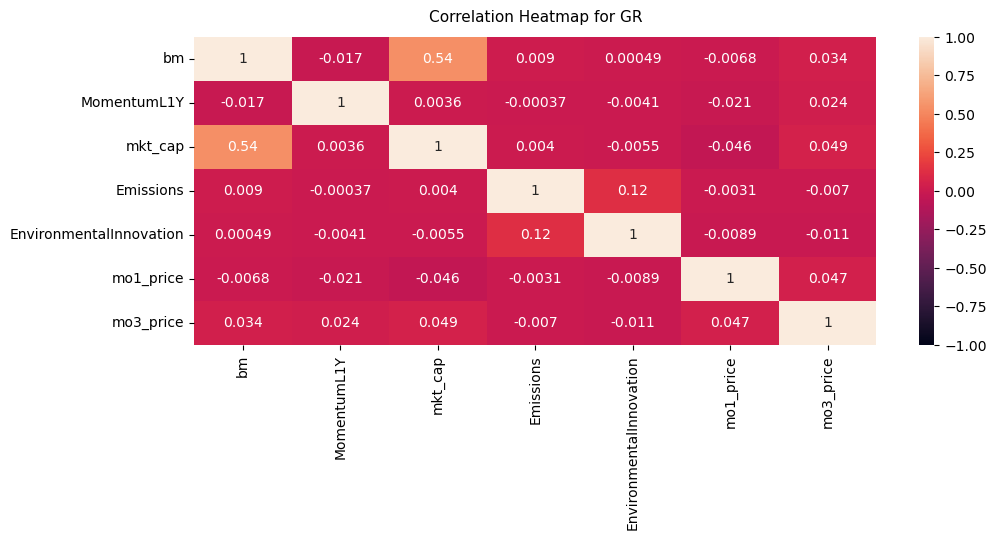

In [25]:
df_gr_f1 = df_gr_f[["bm", "MomentumL1Y", 'mkt_cap', "Emissions", "EnvironmentalInnovation","mo1_price", "mo3_price"]]
plt.figure(figsize=(11, 4))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(df_gr_f1.corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap for GR' , fontdict={'fontsize':11}, pad=11);

In [15]:
var = [["bm", "MomentumL1Y", 'mkt_cap', "mo1_price", "Emissions"], \
       ["bm", "MomentumL1Y", 'mkt_cap', "mo1_price"], \
       ["bm", "MomentumL1Y", 'mkt_cap', "Emissions"], \
       ["bm", "MomentumL1Y", 'mkt_cap'], \
       ["mo1_price", "Emissions"]] 
FE = {"Fixed effects": "fe", "Random effects": "re"} 
# lead variables

## Panel Data Regression Results for USA

In [20]:
list_dict = []
# do for US regression first
dfa1 = df_us_f[["Yr_Mth", "Mth_Ret", "permid", "class", "bm", "MomentumL1Y", 'mkt_cap', "Emissions",  "mo1_price", "mo3_price"]]

# winsorise returns that are way too high or too low
dfa1.loc[dfa1["Mth_Ret"] > 0.8, "Mth_Ret"]  = 0.8 # original without 518722 -->517675
dfa1.loc[dfa1["Mth_Ret"] < -0.8, "Mth_Ret"] = -0.8

dfa1.loc[:,"mkt_cap"] = np.log10(dfa1["mkt_cap"])
for classs in ['brown','green','consumer']:
    dfa2 = dfa1[dfa1["class"]==classs]  # depends a lot on industry
    for dates in [('2005-01', '2022-02')]: #, ('2016-01','2022-02')]:
        dfa3 = setDate(dfa2, dates[0], dates[1])
        stata.pdataframe_to_data(dfa3, force=True)
        stata.run('''gen Yr_Mth2 = date(Yr_Mth, "YM")''')
        df_dates = pystata.stata.pdataframe_from_data(["Yr_Mth2", "Yr_Mth"])     
        stata.run("xtset permid Yr_Mth2")
        
        for v in var:
            v_reg = v.copy()
            v_reg.append("cons")
            v_p = ["p_" + i for i in v_reg]
            print(v_p)
            
            for reg in ["Fixed effects"]:#, "Random effects"]:
                try:
                    cmd = reduce(lambda a, b: a + " " + b, v)
                    cmd = "xtreg Mth_Ret " + cmd + ", " + FE[reg] + " robust"
                    print(reg + " regression for: " + classs + " date range: " + str(dates) + " variables: " + str(v))
                    
                    stata.run(cmd)
                    df_coeff = pystata.stata.get_ereturn()
                    # 1st column and 4th columns
                    df_vals = pystata.stata.get_return()["r(PT)"]
                    
                    res  = dict(zip(v_reg, df_vals[:,0]))
                    df_p = dict(zip(v_p, df_vals[:,3]))  # error with this line
                    res.update(df_p)
                    
                    res["class"] = classs
                    res["period"] = dates[0]
                    res["reg_type"] = reg
                    res["no_of_firms"] = df_coeff["e(N_g)"]
                    res["no_of_obs"] = df_coeff["e(N)"]
                    
                    list_dict.append(res)
                except Exception as e: 
                    print ("ERROR: " + str(e))
df_res = pd.DataFrame.from_records(list_dict, index = range(len(list_dict)))
df_res_t = df_transpose(df_res)
df_res_t.to_clipboard()

C:\Users\jc822081\AppData\Local\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\jc822081\AppData\Local\Temp\ipykernel_22304\4273842618.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,"Yr_Mth1"] = df.loc[:,"Yr_Mth"].map(lambda x : datetime.strptime(x+"-01","%Y-%m-%d"))



Panel variable: permid (unbalanced)
 Time variable: Yr_Mth2, 16527 to 22615, but with gaps
         Delta: 1 unit
['p_bm', 'p_MomentumL1Y', 'p_mkt_cap', 'p_mo1_price', 'p_Emissions', 'p_cons']
Fixed effects regression for: brown date range: ('2005-01', '2022-02') variables: ['bm', 'MomentumL1Y', 'mkt_cap', 'mo1_price', 'Emissions']

Fixed-effects (within) regression               Number of obs     =     93,875
Group variable: permid                          Number of groups  =        886

R-squared:                                      Obs per group:
     Within  = 0.0402                                         min =          1
     Between = 0.0126                                         avg =      106.0
     Overall = 0.0082                                         max =        201

                                                F(5, 885)         =      87.24
corr(u_i, Xb) = -0.8822                         Prob > F          =     0.0000

                               (Std. err. adj

C:\Users\jc822081\AppData\Local\Temp\ipykernel_22304\4273842618.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,"Yr_Mth1"] = df.loc[:,"Yr_Mth"].map(lambda x : datetime.strptime(x+"-01","%Y-%m-%d"))



Panel variable: permid (unbalanced)
 Time variable: Yr_Mth2, 16527 to 22615, but with gaps
         Delta: 1 unit
['p_bm', 'p_MomentumL1Y', 'p_mkt_cap', 'p_mo1_price', 'p_Emissions', 'p_cons']
Fixed effects regression for: green date range: ('2005-01', '2022-02') variables: ['bm', 'MomentumL1Y', 'mkt_cap', 'mo1_price', 'Emissions']

Fixed-effects (within) regression               Number of obs     =    156,697
Group variable: permid                          Number of groups  =      1,997

R-squared:                                      Obs per group:
     Within  = 0.0322                                         min =          1
     Between = 0.0175                                         avg =       78.5
     Overall = 0.0070                                         max =        201

                                                F(5, 1996)        =     158.05
corr(u_i, Xb) = -0.8660                         Prob > F          =     0.0000

                             (Std. err. adjus

C:\Users\jc822081\AppData\Local\Temp\ipykernel_22304\4273842618.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,"Yr_Mth1"] = df.loc[:,"Yr_Mth"].map(lambda x : datetime.strptime(x+"-01","%Y-%m-%d"))



Panel variable: permid (unbalanced)
 Time variable: Yr_Mth2, 16527 to 22615, but with gaps
         Delta: 1 unit
['p_bm', 'p_MomentumL1Y', 'p_mkt_cap', 'p_mo1_price', 'p_Emissions', 'p_cons']
Fixed effects regression for: consumer date range: ('2005-01', '2022-02') variables: ['bm', 'MomentumL1Y', 'mkt_cap', 'mo1_price', 'Emissions']

Fixed-effects (within) regression               Number of obs     =     68,829
Group variable: permid                          Number of groups  =        680

R-squared:                                      Obs per group:
     Within  = 0.0401                                         min =          1
     Between = 0.0228                                         avg =      101.2
     Overall = 0.0121                                         max =        201

                                                F(5, 679)         =     118.07
corr(u_i, Xb) = -0.8135                         Prob > F          =     0.0000

                               (Std. err. 

In [21]:
df_res_t

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
bm,0.036108,0.026666,0.036355,0.026901,,0.048213,0.048384,0.049287,0.049486,,0.040016,0.039367,0.040807,0.040239,
p_bm,0.0,0.000357,0.0,0.000343,,0.0,0.0,0.0,0.0,,0.0,0.0,0.0,0.0,
MomentumL1Y,0.034691,0.033534,0.034874,0.033773,,0.020685,0.018133,0.021471,0.018876,,0.0936,0.056673,0.098911,0.06008,
p_MomentumL1Y,0.000839,0.001231,0.000818,0.00118,,0.00249,0.015845,0.001898,0.013004,,0.0,0.017399,0.0,0.016661,
mkt_cap,1.426017,1.256474,1.432698,1.263214,,1.309462,1.294335,1.331104,1.316082,,1.228915,1.2534,1.260683,1.287156,
p_mkt_cap,0.0,0.0,0.0,0.0,,0.0,0.0,0.0,0.0,,0.0,0.0,0.0,0.0,
Emissions,0.000494,,0.000478,,0.000829,0.000344,,0.000337,,0.000742,0.000023,,-0.000005,,0.000388
p_Emissions,0.225834,,0.241899,,0.066686,0.389275,,0.400361,,0.071131,0.965133,,0.992429,,0.46848
mo1_price,0.014351,0.017371,,,0.025603,0.033146,0.032583,,,0.050028,0.042288,0.043775,,,0.056545
p_mo1_price,0.000002,0.0,,,0.0,0.0,0.0,,,0.0,0.0,0.0,,,0.0


### Panel Data Regression Results for Germany

In [20]:
list_dict = []
# German panel data regressions
dfa1 = df_gr_f[["Yr_Mth", "Mth_Ret", "permid", "class", "bm", "MomentumL1Y", 'mkt_cap', "Emissions",  "mo1_price", "mo3_price"]]

# winsorise returns that are way too high or too low
dfa1.loc[dfa1["Mth_Ret"] > 0.8, "Mth_Ret"]  = 0.8 # original without 518722 -->517675
dfa1.loc[dfa1["Mth_Ret"] < -0.8, "Mth_Ret"] = -0.8

dfa1.loc[:,"mkt_cap"] = np.log10(dfa1["mkt_cap"])
for classs in ['brown','green','consumer']:
    dfa2 = dfa1[dfa1["class"]==classs]  # depends a lot on industry
    for dates in [('2005-01', '2022-02')]: #, ('2016-01','2022-02')]:
        dfa3 = setDate(dfa2, dates[0], dates[1])
        stata.pdataframe_to_data(dfa3, force=True)
        stata.run('''gen Yr_Mth2 = date(Yr_Mth, "YM")''')
        df_dates = pystata.stata.pdataframe_from_data(["Yr_Mth2", "Yr_Mth"])     
        stata.run("xtset permid Yr_Mth2")
        
        for v in var:
            v_reg = v.copy()
            v_reg.append("cons")
            v_p = ["p_" + i for i in v_reg]
            print(v_p)
            
            for reg in ["Fixed effects"]:#, "Random effects"]:
                try:
                    cmd = reduce(lambda a, b: a + " " + b, v)
                    cmd = "xtreg Mth_Ret " + cmd + ", " + FE[reg] + " robust"
                    print(reg + " regression for: " + classs + " date range: " + str(dates) + " variables: " + str(v))
                    
                    stata.run(cmd)
                    df_coeff = pystata.stata.get_ereturn()
                    # 1st column and 4th columns
                    df_vals = pystata.stata.get_return()["r(PT)"]
                    
                    res  = dict(zip(v_reg, df_vals[:,0]))
                    df_p = dict(zip(v_p, df_vals[:,3]))  # error with this line
                    res.update(df_p)
                    
                    res["class"] = classs
                    res["period"] = dates[0]
                    res["reg_type"] = reg
                    res["no_of_firms"] = df_coeff["e(N_g)"]
                    res["Hausman p-val"] = df_vals['r(p)']
                    res["no_of_obs"] = df_coeff["e(N)"]
                    
                    list_dict.append(res)
                except Exception as e: 
                    print ("ERROR: " + str(e))
df_res = pd.DataFrame.from_records(list_dict, index = range(len(list_dict)))
df_res_t = df_transpose(df_res)
df_res_t.to_clipboard()


Panel variable: permid (unbalanced)
 Time variable: Yr_Mth2, 16527 to 22646, but with gaps
         Delta: 1 unit


C:\Users\jc822081\AppData\Local\Temp\ipykernel_17620\4273842618.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,"Yr_Mth1"] = df.loc[:,"Yr_Mth"].map(lambda x : datetime.strptime(x+"-01","%Y-%m-%d"))


['p_bm', 'p_MomentumL1Y', 'p_mkt_cap', 'p_mo1_price', 'p_Emissions', 'p_cons']
Fixed effects regression for: brown date range: ('2005-01', '2022-02') variables: ['bm', 'MomentumL1Y', 'mkt_cap', 'mo1_price', 'Emissions']

Fixed-effects (within) regression               Number of obs     =      3,590
Group variable: permid                          Number of groups  =        105

R-squared:                                      Obs per group:
     Within  = 0.0277                                         min =          2
     Between = 0.0958                                         avg =       34.2
     Overall = 0.0116                                         max =         68

                                                F(5, 104)         =       9.53
corr(u_i, Xb) = -0.8437                         Prob > F          =     0.0000

                               (Std. err. adjusted for 105 clusters in permid)
------------------------------------------------------------------------------
  

                               (Std. err. adjusted for 105 clusters in permid)
------------------------------------------------------------------------------
             |               Robust
     Mth_Ret | Coefficient  std. err.      t    P>|t|     [95% conf. interval]
-------------+----------------------------------------------------------------
   mo1_price |   .0688068    .027516     2.50   0.014     .0142414    .1233721
   Emissions |  -.0022543   .0025418    -0.89   0.377    -.0072948    .0027862
       _cons |  -.0411049   .0213166    -1.93   0.057    -.0833766    .0011667
-------------+----------------------------------------------------------------
     sigma_u |  .05034121
     sigma_e |  .17196487
         rho |  .07893308   (fraction of variance due to u_i)
------------------------------------------------------------------------------
ERROR: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

Panel variabl

C:\Users\jc822081\AppData\Local\Temp\ipykernel_17620\4273842618.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,"Yr_Mth1"] = df.loc[:,"Yr_Mth"].map(lambda x : datetime.strptime(x+"-01","%Y-%m-%d"))



Fixed-effects (within) regression               Number of obs     =      1,868
Group variable: permid                          Number of groups  =         70

R-squared:                                      Obs per group:
     Within  = 0.0180                                         min =          1
     Between = 0.0028                                         avg =       26.7
     Overall = 0.0030                                         max =         68

                                                F(4, 69)          =       6.58
corr(u_i, Xb) = -0.8543                         Prob > F          =     0.0002

                                (Std. err. adjusted for 70 clusters in permid)
------------------------------------------------------------------------------
             |               Robust
     Mth_Ret | Coefficient  std. err.      t    P>|t|     [95% conf. interval]
-------------+----------------------------------------------------------------
          bm |  -.0000547   

C:\Users\jc822081\AppData\Local\Temp\ipykernel_17620\4273842618.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,"Yr_Mth1"] = df.loc[:,"Yr_Mth"].map(lambda x : datetime.strptime(x+"-01","%Y-%m-%d"))


ERROR: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
['p_bm', 'p_MomentumL1Y', 'p_mkt_cap', 'p_Emissions', 'p_cons']
Fixed effects regression for: consumer date range: ('2005-01', '2022-02') variables: ['bm', 'MomentumL1Y', 'mkt_cap', 'Emissions']

Fixed-effects (within) regression               Number of obs     =      1,395
Group variable: permid                          Number of groups  =         47

R-squared:                                      Obs per group:
     Within  = 0.0175                                         min =          1
     Between = 0.0020                                         avg =       29.7
     Overall = 0.0017                                         max =         68

                                                F(4, 46)          =      24.01
corr(u_i, Xb) = -0.6708                         Prob > F          =     0.0000

                                (Std. err. adjusted for 47 c

ValueError: Must pass non-zero number of levels/codes

In [65]:
df_res_t

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
bm,-0.000061,-0.000063,-0.000062,-0.000062,,-0.00006,-0.000054,-0.000055,-0.000047,,-0.000036,-0.000036,-0.000032,-0.000032,
p_bm,0.022094,0.025512,0.009065,0.008551,,0.034069,0.036466,0.030063,0.032995,,0.0,0.0,0.000001,0.000001,
MomentumL1Y,0.008799,0.011352,0.008257,0.010531,,0.018917,0.032332,0.017836,0.031366,,0.054482,0.091193,0.044321,0.080274,
p_MomentumL1Y,0.410275,0.365401,0.418188,0.373876,,0.631191,0.448796,0.652545,0.463314,,0.372954,0.124279,0.460081,0.17002,
mkt_cap,2.280147,2.167832,2.193215,2.080572,,1.754229,1.113456,1.794873,1.137346,,1.526266,1.535471,1.486183,1.497355,
p_mkt_cap,0.0,0.0,0.0,0.0,,0.000171,0.003909,0.000065,0.002894,,0.008218,0.006177,0.007339,0.005581,
Emissions,-0.00271,,-0.003023,,-0.002254,-0.001792,,-0.001278,,-0.000974,0.002694,,0.002809,,0.001881
p_Emissions,0.277018,,0.22752,,0.377181,0.641258,,0.735598,,0.800941,0.258771,,0.237626,,0.415082
mo1_price,0.086984,0.098691,,,0.068807,0.118007,0.131133,,,0.122126,0.085313,0.088,,,0.063112
p_mo1_price,0.002043,0.000174,,,0.013959,0.004389,0.001143,,,0.003429,0.000071,0.000087,,,0.002496


### Section for Hausman Test (random effects vs fixed effects)

In [87]:
# random effects are needed for the sentiment and emissions data
list_dict = []
p_vals = []
chi_sq = []
# German regression first
dfa1 = df_gr_f[["Yr_Mth", "Mth_Ret", "permid", "class", "bm", "MomentumL1Y", 'mkt_cap', "Emissions",  "mo1_price", "mo3_price"]]

# winsorise returns that are way too high or too low
dfa1.loc[dfa1["Mth_Ret"] > 0.8, "Mth_Ret"]  = 0.8 # original without 518722 -->517675
dfa1.loc[dfa1["Mth_Ret"] < -0.8, "Mth_Ret"] = -0.8

dfa1.loc[:,"mkt_cap"] = np.log10(dfa1["mkt_cap"])
for classs in ['brown','green','consumer']:
    dfa2 = dfa1[dfa1["class"]==classs]  # depends a lot on industry
    for dates in [('2005-01', '2022-02')] : #, ('2016-01','2022-02')]:
        dfa3 = setDate(dfa2, dates[0], dates[1])
        stata.pdataframe_to_data(dfa3, force=True)
        stata.run('''gen Yr_Mth2 = date(Yr_Mth, "YM")''')
        df_dates = pystata.stata.pdataframe_from_data(["Yr_Mth2", "Yr_Mth"])     
        stata.run("xtset permid Yr_Mth2")
        
        for v in var:
            v_reg = v.copy()
            v_reg.append("cons")
            v_p = ["p_" + i for i in v_reg]
             
            try:
                cmd = reduce(lambda a, b: a + " " + b, v)
            
                cmd_fe = "xtreg Mth_Ret " + cmd + ", fe"
                stata.run(cmd_fe)
                stata.run("estimates store fixed")
                cmd_re = "xtreg Mth_Ret " + cmd + ", re"
                stata.run(cmd_re)
                stata.run("estimates store random")
                stata.run("hausman fixed random, sigmamore")
                
                df_coeff = pystata.stata.get_ereturn()
                # 1st column and 4th columns
                df_vals = pystata.stata.get_return()
                p_vals.append(df_vals['r(p)'])
                chi_sq.append(df_vals['r(chi2)'])
                
                res  = dict(zip(v_reg, df_vals[:,0]))
                df_p = dict(zip(v_p, df_vals[:,3]))  # error with this line
                res.update(df_p) 
                res["class"] = classs
                res["period"] = dates[0]
                res["reg_type"] = reg
                res["no_of_firms"] = df_coeff["e(N_g)"]
                res["Hausman p-val"] = df_vals['r(p)']
                
                res["no_of_obs"] = df_coeff["e(N)"]
                list_dict.append(res)
                print(res)
            except Exception as e: 
                print ("ERROR: " + str(e))
#df_res = pd.DataFrame.from_records(list_dict, index = range(len(list_dict)))
#df_res_t = df_transpose(df_res)
#df_res_t.to_clipboard()

C:\Users\jc822081\AppData\Local\Temp\ipykernel_22304\4273842618.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,"Yr_Mth1"] = df.loc[:,"Yr_Mth"].map(lambda x : datetime.strptime(x+"-01","%Y-%m-%d"))



Panel variable: permid (unbalanced)
 Time variable: Yr_Mth2, 16527 to 22646, but with gaps
         Delta: 1 unit

Fixed-effects (within) regression               Number of obs     =      3,590
Group variable: permid                          Number of groups  =        105

R-squared:                                      Obs per group:
     Within  = 0.0277                                         min =          2
     Between = 0.0958                                         avg =       34.2
     Overall = 0.0116                                         max =         68

                                                F(5, 3480)        =      19.83
corr(u_i, Xb) = -0.8437                         Prob > F          =     0.0000

------------------------------------------------------------------------------
     Mth_Ret | Coefficient  Std. err.      t    P>|t|     [95% conf. interval]
-------------+----------------------------------------------------------------
          bm |   -.000061   

ERROR: unhashable type: 'slice'

Fixed-effects (within) regression               Number of obs     =      3,590
Group variable: permid                          Number of groups  =        105

R-squared:                                      Obs per group:
     Within  = 0.0235                                         min =          2
     Between = 0.0932                                         avg =       34.2
     Overall = 0.0101                                         max =         68

                                                F(4, 3481)        =      20.96
corr(u_i, Xb) = -0.8392                         Prob > F          =     0.0000

------------------------------------------------------------------------------
     Mth_Ret | Coefficient  Std. err.      t    P>|t|     [95% conf. interval]
-------------+----------------------------------------------------------------
          bm |  -.0000622   .0000259    -2.40   0.017     -.000113   -.0000113
 MomentumL1Y |   .0082565   .007


Random-effects GLS regression                   Number of obs     =      3,668
Group variable: permid                          Number of groups  =        105

R-squared:                                      Obs per group:
     Within  = 0.0028                                         min =          2
     Between = 0.0257                                         avg =       34.9
     Overall = 0.0037                                         max =         68

                                                Wald chi2(2)      =      12.09
corr(u_i, X) = 0 (assumed)                      Prob > chi2       =     0.0024

------------------------------------------------------------------------------
     Mth_Ret | Coefficient  Std. err.      z    P>|z|     [95% conf. interval]
-------------+----------------------------------------------------------------
   mo1_price |   .0753017   .0223258     3.37   0.001      .031544    .1190594
   Emissions |  -.0021561   .0028977    -0.74   0.457    -.00783

C:\Users\jc822081\AppData\Local\Temp\ipykernel_22304\4273842618.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,"Yr_Mth1"] = df.loc[:,"Yr_Mth"].map(lambda x : datetime.strptime(x+"-01","%Y-%m-%d"))



Random-effects GLS regression                   Number of obs     =      1,868
Group variable: permid                          Number of groups  =         70

R-squared:                                      Obs per group:
     Within  = 0.0125                                         min =          1
     Between = 0.0606                                         avg =       26.7
     Overall = 0.0156                                         max =         68

                                                Wald chi2(5)      =      29.46
corr(u_i, X) = 0 (assumed)                      Prob > chi2       =     0.0000

------------------------------------------------------------------------------
     Mth_Ret | Coefficient  Std. err.      z    P>|z|     [95% conf. interval]
-------------+----------------------------------------------------------------
          bm |  -.0000267   .0000122    -2.19   0.029    -.0000507   -2.77e-06
 MomentumL1Y |   .0904029   .0303176     2.98   0.003     .03098


Random-effects GLS regression                   Number of obs     =      1,868
Group variable: permid                          Number of groups  =         70

R-squared:                                      Obs per group:
     Within  = 0.0059                                         min =          1
     Between = 0.0683                                         avg =       26.7
     Overall = 0.0096                                         max =         68

                                                Wald chi2(4)      =      18.09
corr(u_i, X) = 0 (assumed)                      Prob > chi2       =     0.0012

------------------------------------------------------------------------------
     Mth_Ret | Coefficient  Std. err.      z    P>|z|     [95% conf. interval]
-------------+----------------------------------------------------------------
          bm |  -.0000271   .0000123    -2.21   0.027    -.0000511   -3.08e-06
 MomentumL1Y |    .090613    .030401     2.98   0.003     .03102

------------------------------------------------------------------------------
     Mth_Ret | Coefficient  Std. err.      z    P>|z|     [95% conf. interval]
-------------+----------------------------------------------------------------
   mo1_price |   .1169367   .0342672     3.41   0.001     .0497742    .1840992
   Emissions |  -.0012182    .004809    -0.25   0.800    -.0106436    .0082072
       _cons |  -.0713948   .0271545    -2.63   0.009    -.1246166    -.018173
-------------+----------------------------------------------------------------
     sigma_u |  .01829232
     sigma_e |  .18280234
         rho |  .00991395   (fraction of variance due to u_i)
------------------------------------------------------------------------------

                 ---- Coefficients ----
             |      (b)          (B)            (b-B)     sqrt(diag(V_b-V_B))
             |     fixed        random       Difference       Std. err.
-------------+-------------------------------------------------

C:\Users\jc822081\AppData\Local\Temp\ipykernel_22304\4273842618.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,"Yr_Mth1"] = df.loc[:,"Yr_Mth"].map(lambda x : datetime.strptime(x+"-01","%Y-%m-%d"))



Random-effects GLS regression                   Number of obs     =      1,395
Group variable: permid                          Number of groups  =         47

R-squared:                                      Obs per group:
     Within  = 0.0111                                         min =          1
     Between = 0.5568                                         avg =       29.7
     Overall = 0.0317                                         max =         68

                                                Wald chi2(5)      =      39.18
corr(u_i, X) = 0 (assumed)                      Prob > chi2       =     0.0000

------------------------------------------------------------------------------
     Mth_Ret | Coefficient  Std. err.      z    P>|z|     [95% conf. interval]
-------------+----------------------------------------------------------------
          bm |  -9.53e-06   7.36e-06    -1.30   0.195     -.000024    4.89e-06
 MomentumL1Y |   .2359559   .0449836     5.25   0.000     .14778


Random-effects GLS regression                   Number of obs     =      1,395
Group variable: permid                          Number of groups  =         47

R-squared:                                      Obs per group:
     Within  = 0.0076                                         min =          1
     Between = 0.4286                                         avg =       29.7
     Overall = 0.0223                                         max =         68

                                                Wald chi2(4)      =      25.54
corr(u_i, X) = 0 (assumed)                      Prob > chi2       =     0.0000

------------------------------------------------------------------------------
     Mth_Ret | Coefficient  Std. err.      z    P>|z|     [95% conf. interval]
-------------+----------------------------------------------------------------
          bm |  -.0000114   8.26e-06    -1.37   0.169    -.0000275    4.84e-06
 MomentumL1Y |   .2047382   .0455348     4.50   0.000     .11549


Random-effects GLS regression                   Number of obs     =      1,404
Group variable: permid                          Number of groups  =         47

R-squared:                                      Obs per group:
     Within  = 0.0031                                         min =          1
     Between = 0.2979                                         avg =       29.9
     Overall = 0.0050                                         max =         68

                                                Wald chi2(2)      =       5.34
corr(u_i, X) = 0 (assumed)                      Prob > chi2       =     0.0691

------------------------------------------------------------------------------
     Mth_Ret | Coefficient  Std. err.      z    P>|z|     [95% conf. interval]
-------------+----------------------------------------------------------------
   mo1_price |   .0712926   .0319029     2.23   0.025     .0087641    .1338211
   Emissions |   .0018451   .0033058     0.56   0.577    -.00463

In [88]:
chi_sq

[53.21542481997924,
 55.68190626648527,
 43.465539754504555,
 45.40323307905554,
 3.7254760710295987,
 38.683827643373704,
 50.376084539310426,
 38.683246461823536,
 51.68798378960726,
 0.8678143135501066,
 68.68129054981628,
 69.23314486964149,
 62.78379835405531,
 66.04189569777006,
 12.849219383808196]